In [30]:
import pandas as pd
df = pd.read_csv('C:/Users/boopathi_j/Desktop/Books/COLCSV.csv')
df.head(10)

,Cause of Loss,Label
0,(C&R'D 5/23/13) PAIN AND NUMBNESS RT SIDE OF B...,Other
1,**MASTER** RT SHOULDER STRAIN,Other
2,<blank>,Other
3,01/15/07-PAIN IN RIGHT ELBOW- EE STATED THAT H...,Strain or injury by
4,"01/21/08, NLT. HEMATOMA/LEFT KNEE. WAS WALKING...","Slip, trip or fall"
5,"06/01/2006, NLT RT SHOULDER STRAIN. EE IS STAT...",Strain or injury by
6,"06/03/08, CONCUSSION. EE WAS PUTTING A BOX IN ...","Slip, trip or fall"
7,53 year old Maintenance Technician alleges inj...,Strain or injury by
8,A 63 year old Maintenance Technician filed a s...,Strain or injury by
9,Absor/Ing/Inhale,Other


In [33]:
df.columns

Index(['Cause_of_Loss', 'Label'], dtype='object')

In [32]:
df.columns = ['Cause_of_Loss', 'Label']

In [34]:
df['category_id'] = df['Label'].factorize()[0]
from io import StringIO
category_id_df = df[['Label', 'category_id']].drop_duplicates().sort_values('category_id')
print(category_id_df.values)
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Label']].values)

[['Other' 0]
 ['Strain or injury by' 1]
 ['Slip, trip or fall' 2]
 ['Struck By' 3]
 ['Cut or puncture' 4]
 ['Motor Vehicle' 5]]


In [23]:
print(id_to_category)

{0: 'Other', 1: 'Strain or injury by', 2: 'Slip, trip or fall', 3: 'Struck By', 4: 'Cut or puncture', 5: 'Motor Vehicle'}


In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Label').Cause_of_Loss.count().plot.bar(ylim=0)
plt.show()

<Figure size 800x600 with 1 Axes>

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Cause_of_Loss).toarray()
labels = df.category_id
features.shape



#exporting my model
pickle.dump(tfidf,open("Vector_model.pkl","wb"))

In [37]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Label, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  
    
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Label))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Cut or puncture':
  . Most correlated unigrams:
       . tool
       . cut
  . Most correlated bigrams:
       . cut punctured
       . punctured scraped
# 'Motor Vehicle':
  . Most correlated unigrams:
       . caught
       . fall
  . Most correlated bigrams:
       . fall slip
       . slip trip
# 'Other':
  . Most correlated unigrams:
       . repetitive
       . bilateral
  . Most correlated bigrams:
       . fall slip
       . slip trip
# 'Slip, trip or fall':
  . Most correlated unigrams:
       . trip
       . fall
  . Most correlated bigrams:
       . fall slip
       . slip trip
# 'Strain or injury by':
  . Most correlated unigrams:
       . cumulative
       . burn
  . Most correlated bigrams:
       . scald contact
       . burn scald
# 'Struck By':
  . Most correlated unigrams:
       . machinery
       . caught
  . Most correlated bigrams:
       . slip trip
       . caught object


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Cause_of_Loss'], df['Label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)



In [44]:
print(clf.predict(count_vect.transform(["Moving refrigerator.                                                                                                                                                                                                                                      "])))

['Strain or injury by']


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The mi

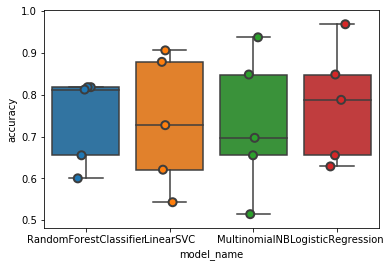

In [40]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [41]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.735171
LogisticRegression        0.777771
MultinomialNB             0.730483
RandomForestClassifier    0.740807
Name: accuracy, dtype: float64

In [44]:
from sklearn.model_selection import train_test_split

model = LogisticRegression()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)






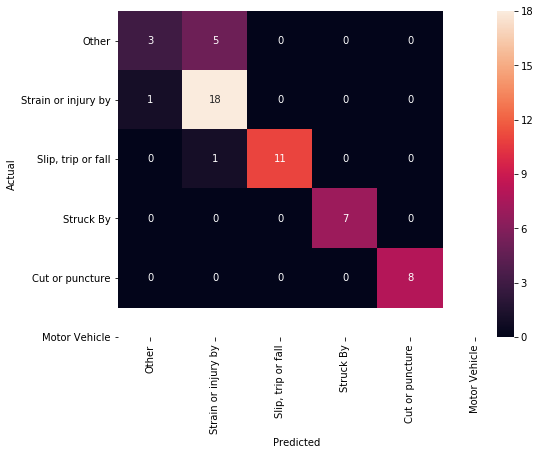

In [45]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [49]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 1:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Label', 'Cause_of_Loss']])
      print('')

'Strain or injury by' predicted as 'Other' : 1 examples.


,Label,Cause_of_Loss
27,Strain or injury by,"Arm, Lower"


IndexError: index 5 is out of bounds for axis 0 with size 5

In [72]:
import pickle
#exporting my model
pickle.dump(model,open("COL_model.pkl","wb"))




In [63]:
#loading a model from a file called model.pkl
model_load = pickle.load(open("COL_model.pkl","rb"))